In [1]:
ls

EA_PPO.ipynb           PPO_EA_Pseudo.ipynb    UnityAPI.ipynb
Model.py               README.md              __pycache__/
PPO_Base.ipynb         TRPO_Base_Model.ipynb


In [1]:
import os
import sys

# Define the path to ml-agents-envs
folder_path = "../ml-agents/ml-agents-envs"
sys.path.append(os.path.abspath(folder_path))

# Import UnityEnvironment
from mlagents_envs.environment import UnityEnvironment

In [3]:
import numpy as np
import torch
import gymnasium as gym
import time
import math
import sys
import numpy as np
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.exception import UnityWorkerInUseException
from mlagents_envs.base_env import ActionTuple
import gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
from torch import optim
from torch.distributions.categorical import Categorical
import random
from torch.distributions import Normal
from mlagents_envs.environment import UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from collections import deque


I0000 00:00:1731562749.657344 9160697 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

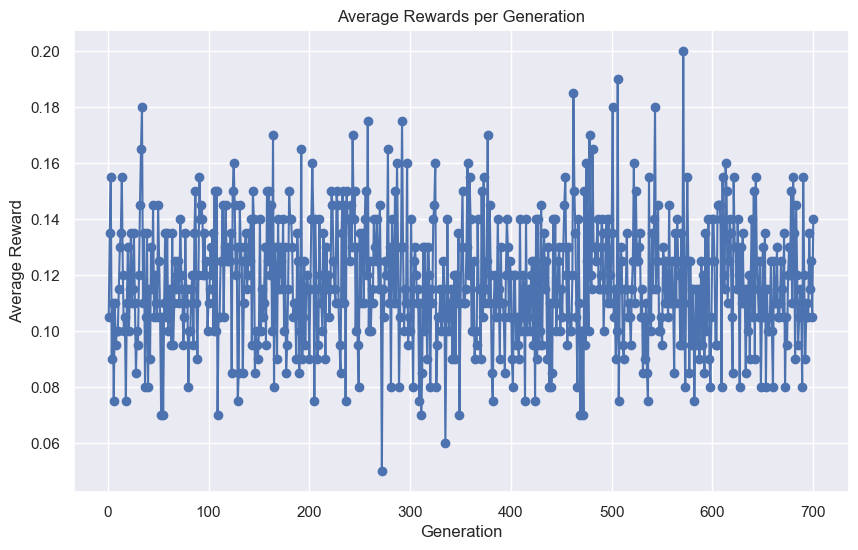

Thread 0x171443000 may have been prematurely finalized
[Physics::Module] Cleanup current backned.
[Physics::Module] Id: 0xf2b8ea05
Thread 0x1701eb000 may have been prematurely finalized
Thread 0x170303000 may have been prematurely finalized
Thread 0x17038f000 may have been prematurely finalized
Thread 0x170277000 may have been prematurely finalized


In [4]:
sns.set()

class ActorCriticNN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU())

        self.policy_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64,action_dim))

        self.value_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def value(self, obs):
        z = self.shared_layers(obs)
        value = self.value_layers(z)
        return value

    def policy(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        return policy_logits

    def forward(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        value = self.value_layers(z)
        return policy_logits, value

#trainer
class PPOTrainer():
    def __init__(self, actor_critic, ppo_clip_val, target_kl_div, policy_lr, value_lr, max_policy_train_iters = 80, 
                 value_train_iters = 80, entropy_coeff = 0.01):
        self.entropy_coeff = entropy_coeff
        self.ac = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters
    
        policy_params = list(self.ac.shared_layers.parameters()) + \
            list(self.ac.policy_layers.parameters())
        self.policy_optim = optim.Adam(policy_params, lr = policy_lr)
    
        value_params = list(self.ac.shared_layers.parameters()) + \
            list(self.ac.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr = value_lr)

    def train_policy(self, obs, acts, old_log_probs, gaes):
        """
        Train the policy using PPO with the given observations, actions, old log probabilities, and GAEs.
        """
        # Forward pass through the policy network
        new_logits = self.ac.policy(obs)  # Output from policy network
        new_logits = Categorical(logits=new_logits)

        acts = acts.squeeze(1)
        
        # Ensure actions are reshaped to 1D if necessary
        acts = acts.reshape(-1)  # Flatten actions to a 1D tensor
        
        # Ensure batch sizes match
        batch_size = new_logits.logits.size(0)
        if acts.size(0) != batch_size:
            #print(f"Warning: Mismatch in batch size: logits size {batch_size}, actions size {acts.size(0)}")
            acts = acts[:batch_size]  # Slice actions to match logits batch size
        
        # Compute the log probabilities of the actions
        new_log_probs = new_logits.log_prob(acts)  # This requires acts to be a 1D tensor, not 2D
        
        # Compute the policy ratio
        policy_ratio = torch.exp(new_log_probs - old_log_probs)
        clipped_ratio = policy_ratio.clamp(1 - self.ppo_clip_val, 1 + self.ppo_clip_val)
        
        # Calculate the loss
        loss = -torch.min(policy_ratio * gaes, clipped_ratio * gaes).mean()
        
        # Add entropy bonus to encourage exploration
        #entropy_loss = -torch.mean(new_logits.entropy())
        #loss = loss - self.entropy_coeff * entropy_loss

        # Backpropagate and optimize (assuming optimizer is defined)
        self.policy_optim.zero_grad()
        loss.backward()
        self.policy_optim.step()

        kl_div = (old_log_probs - new_log_probs).mean()


    def train_value(self, obs, returns):

        for _ in range (self.value_train_iters):
            self.value_optim.zero_grad()
    
            values = self.ac.value(obs)
            value_loss = (returns-values) ** 2
            value_loss = value_loss.mean()
    
            value_loss.backward()
            self.value_optim.step()

class ActorCriticChromosome:
    def __init__(self, state_dim, action_dim):
        # Actor-Critic neural network
        self.model = ActorCriticNN(state_dim, action_dim)

        #Hyperparameters
        self.policy_lr = random.uniform(1e-5, 1e-2)  # Expanded range
        self.value_lr = random.uniform(1e-5, 1e-2)  # Expanded range
        self.ppo_clip_val = random.uniform(0.1, 0.4)  # Expanded range
        self.target_kl_div = random.uniform(0.001, 0.05)

def create_population(pop_size, state_dim, action_dim):
    return [ActorCriticChromosome(state_dim, action_dim) for _ in range(pop_size)]

"""
When initializing PPOTrainer, you're passing the individual's hyperparameters (policy_lr, value_lr, etc.) 
to ensure the evaluation process reflects the effect of those hyperparameters.
You're sampling actions from the model and accumulating rewards to calculate the fitness score.
"""

from mlagents_envs.base_env import ActionTuple

def evaluate_population(population, env, behavior_name):
    """
    Evaluate each individual in the population within the Unity environment.
    
    Parameters:
        population (list): List of policies (or models) to evaluate.
        env (UnityEnvironment): Unity environment object.
        behavior_name (str): Name of the behavior being evaluated.
        
    Returns:
        fitness_scores (list): List of fitness scores (rewards) for each individual.
    """
    fitness_scores = []

    for policy in population:
        # Reset the environment and initialize reward for the episode
        env.reset()
        total_reward = 0
        done = False

        while not done:
            # Get the current observation and decision steps
            decision_steps, terminal_steps = env.get_steps(behavior_name)

            if len(decision_steps) > 0:
                # Extract observation data for the agent
                obs = decision_steps.obs[0][0]  # Get the first observation from the agent (assuming single agent)

                # Convert obs to a PyTorch tensor with dtype float32
                obs_tensor = torch.tensor(obs, dtype=torch.float32)

                # Ensure the tensor is correctly shaped for the model (batch dimension)
                if len(obs_tensor.shape) == 1:  # if obs is 1D, add a batch dimension
                    obs_tensor = obs_tensor.unsqueeze(0)

                # Get the action from the policy model
                logits, _ = policy.model(obs_tensor)  # Assuming 'policy' method returns both logits and value

                # Convert logits into a categorical distribution and sample an action
                action_dist = Categorical(logits=logits)
                action = action_dist.sample().item()  # Get the action as a scalar

                # Ensure action is a 2D array with shape (1, 2) for continuous action space
                action = np.array([[action, action]])  # Example to make action a 2D array

                # Convert the action to the correct Unity format
                action_tuple = ActionTuple(continuous=action)

                # Set the action and step the environment
                env.set_actions(behavior_name, action_tuple)
                env.step()

            # Collect rewards from decision and terminal steps
            for agent_id in decision_steps:
                total_reward += decision_steps[agent_id].reward
            
            for agent_id in terminal_steps:
                total_reward += terminal_steps[agent_id].reward
                done = True  # End of episode if there are terminal steps

        # Append the total reward as the fitness score for the policy
        fitness_scores.append(total_reward)

    return fitness_scores



def select_parents(population, fitness_scores, num_parents):
   # Get indices that would sort the fitness scores in descending order
    sorted_indices = np.argsort(fitness_scores)[::-1]  # Reverse for descending order
    
    # Select the best parents based on the sorted indices
    parents = np.array(population)[sorted_indices][:num_parents]
    return parents.tolist()

def crossover(parent1, parent2):
    child = ActorCriticChromosome(state_dim, action_dim)
    
    # Crossover the weights of the model in a way that keeps useful features
    for param1, param2, param_child in zip(parent1.model.parameters(), parent2.model.parameters(), child.model.parameters()):
        param_child.data = (param1.data + param2.data) / 2  # Averaging weights of the parents

    # Crossover the hyperparameters (keeping them in a range that allows for continued learning)
    child.policy_lr = (parent1.policy_lr + parent2.policy_lr) / 2
    child.value_lr = (parent1.value_lr + parent2.value_lr) / 2
    child.ppo_clip_val = (parent1.ppo_clip_val + parent2.ppo_clip_val) / 2
    child.target_kl_div = (parent1.target_kl_div + parent2.target_kl_div) / 2
    
    return child


def mutate(individual, mutation_rate=0.01):
    for param in individual.model.parameters():
        if random.random() < mutation_rate:
            param.data += torch.randn(param.size()) * 0.1  # Add small random noise
    
    # Mutate hyperparameters with greater changes
    if random.random() < mutation_rate:
        individual.policy_lr += random.uniform(-5e-4, 5e-4)  # Much larger mutation range
    if random.random() < mutation_rate:
        individual.value_lr += random.uniform(-5e-4, 5e-4)  # Increased mutation range
    if random.random() < mutation_rate:
        individual.ppo_clip_val += random.uniform(-0.1, 0.1)  # Increased mutation range
    if random.random() < mutation_rate:
        individual.target_kl_div += random.uniform(-0.01, 0.01)  # Increased mutation range



def discount_rewards(rewards, gamma = 0.99):
    """
    Return discounted rewards based on the given rewards and the gamma param.
    """

    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards)-1)):
        new_rewards.append(float(rewards[i]) + gamma * new_rewards[-1])
    return np.array(new_rewards[::-1])

def calculate_gaes(rewards, values, gamma = 0.99, decay = 0.97):
    """
    Return the General Advantage Estimates from the given rewards and values.
    Paper: https://arxiv.org/abs/1506.02438
    """

    next_values = np.concatenate([values[1:], [0]])
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas)-1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])

    return np.array(gaes[::-1])

def unity_rollout(model, env, name, max_steps=1000, gamma=0.99, lam=0.95):
    """
    Perform a rollout of the model in the Unity environment and collect rewards, 
    actions, values, and log probabilities.

    Parameters:
        model (torch.nn.Module): The trained policy model.
        env (UnityEnvironment): The Unity environment object.
        name (str): The behavior name for the agent.
        max_steps (int): Maximum number of steps in an episode.

    Returns:
        train_data (tuple): Collected training data (observations, actions, rewards, values, log_probs).
        reward (float): Total reward for the episode.
    """
    train_data = [[], [], [], [], []]  # To store observations, actions, rewards, values, log_probs
    total_reward = 0
    done = False
    step = 0

    # Reset environment at the start
    env.reset()

    while not done and step < max_steps:
        decision_steps, terminal_steps = env.get_steps(name)

        if len(decision_steps) > 0:
            # Get observation from the environment
            obs = decision_steps.obs[0][0]  # Assuming single agent
            
            # Convert the observation to a tensor
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

            # Get the action and value from the policy model
            action_logits, value = model(obs_tensor)

            # Ensure the action is a 2D tensor (1, 2) for continuous action space
            if action_logits.shape != (1, 2):
                action_logits = action_logits.reshape(1, 2)  # Reshape to (1, 2) if necessary

            # Create action distribution and sample an action
            act_dist = Categorical(logits=action_logits)
            action = act_dist.sample()
            act_log_prob = act_dist.log_prob(action).item()

            # Ensure action has the correct shape (1, 2) for continuous action
            if action.shape == (1,):  # Check if action is a single value
                action = action.unsqueeze(0)  # Reshape to (1, 2) if it's a scalar
                action = action.expand(1, 2)  # Duplicate the value to match the shape (1, 2)

            # Store the observation, action, reward, value, and log probability
            train_data[0].append(obs)  # Observation
            train_data[1].append(action.detach().numpy())  # Action
            train_data[2].append(decision_steps[0].reward)  # Reward (for decision steps)
            train_data[3].append(value.item())  # Value from the model
            train_data[4].append(act_log_prob)  # Log probability of the action

            # Set the action and step the environment
            action_tuple = ActionTuple()
            action_tuple.add_continuous(action.detach().numpy())  # Detach the tensor before converting to numpy
            env.set_actions(name, action_tuple)
            env.step()

            # Collect rewards
            for agent_id in decision_steps:
                total_reward += decision_steps[agent_id].reward

            # Check if the episode has ended (by terminal steps)
            if len(terminal_steps) > 0:
                for agent_id in terminal_steps:
                    total_reward += terminal_steps[agent_id].reward
                    # Store at the end of the episode
                    train_data[0].append(obs)
                    train_data[1].append(action.detach().numpy())
                    train_data[2].append(terminal_steps[agent_id].reward)
                    train_data[3].append(value.item())  # Final value prediction
                    train_data[4].append(act_log_prob)  # Final log probability
                done = True

        step += 1

    # Convert lists to numpy arrays
    train_data = [np.asarray(x) for x in train_data]

    # Calculate GAEs using the stored rewards and values
    train_data[3] = calculate_gaes(train_data[2], train_data[3], gamma, lam)

    return train_data, total_reward

worker_id = 0
show_visuals = False;
while worker_id <= 64:
    try:
        env = UnityEnvironment(file_name="../Evo_Project", worker_id=worker_id, no_graphics=not show_visuals)
        env.reset()
        break
    except UnityWorkerInUseException:
        worker_id += 1

# Keep top N best individuals
def elitism(population, fitness_scores, num_best=5):
    sorted_indices = np.argsort(fitness_scores)[::-1]  # Descending order of fitness scores
    best_individuals = [population[i] for i in sorted_indices[:num_best]]
    return best_individuals

def adaptive_mutation_rate(generation, max_generations, initial_rate=0.1, min_rate=0.01):
    # Linearly decay mutation rate from initial_rate to min_rate over generations
    rate = initial_rate - (initial_rate - min_rate) * (generation / max_generations)
    return rate

def evolutionary_process(population, fitness_scores, num_parents, pop_size):
    
    # Create next generation using selected parents
    next_generation = []
    for i in range(pop_size):
        parent1, parent2 = np.random.choice(parents, 2, replace=False)  # Select parents from the elite
        child = crossover(parent1, parent2)
        mutate(child)  # Apply mutation
        next_generation.append(child)

    return next_generation

behavior_name = list(env.behavior_specs.keys())[0]
spec = env.behavior_specs[behavior_name]
state_dim = sum([obs.shape[0] for obs in spec.observation_specs])  # Total observation dimensions
action_spec = spec.action_spec
action_dim = action_spec.discrete_size if action_spec.is_discrete() else action_spec.continuous_size

# Define the environment and parameters
# state_dim = env.observation_space.shape[0]
# action_dim = env.action_space.n
n_episodes = 200
print_freq = 20
pop_size = 50
num_parents = 10
num_generations = 700


# Initialize the population
population = create_population(pop_size, state_dim, action_dim)
avg_rewards_per_generation = []

for generation in range(num_generations):
        generation_rewards = []
    
        # Evaluate the current population
        fitness_scores = evaluate_population(population, env, behavior_name)

        # Elitism: select the top 5 individuals based on fitness
        parents = elitism(population, fitness_scores, num_best=5)

        # Select the best parents based on fitness scores
        parents = select_parents(population, fitness_scores, num_parents)

        # Apply the evolutionary process to generate the next generation
        next_generation = evolutionary_process(parents, fitness_scores, num_parents, pop_size)

        print(f"Generation: {generation + 1}")

        # Fine-tune the best policy using PPO
        best_policy = parents[0]  # Select the best policy for further training with PPO
        ppo = PPOTrainer(best_policy.model, ppo_clip_val=best_policy.ppo_clip_val, target_kl_div=best_policy.target_kl_div,
                         policy_lr=best_policy.policy_lr, value_lr=best_policy.value_lr)

        ep_rewards = []
        for episode_idx in range(n_episodes):
            # Perform rollout
            train_data, reward = unity_rollout(best_policy.model, env, behavior_name)
            ep_rewards.append(reward)

            # Permute the indices
            permute_idxs = np.random.permutation(len(train_data[0]))

            # Convert the train_data[0] (observations) and train_data[1] (actions) to torch tensors
            obs = torch.tensor(np.array(train_data[0])[permute_idxs], dtype=torch.float32)
            act = torch.tensor(np.array(train_data[1])[permute_idxs], dtype=torch.float32)
            gaes = torch.tensor(np.array(train_data[3])[permute_idxs], dtype=torch.float32)  # If using GAEs, ensure it's in train_data[3]

            act_log_probs = torch.tensor(train_data[4][permute_idxs], dtype=torch.float32)

            # Value Data
            returns = discount_rewards(train_data[2])[permute_idxs]
            returns = torch.tensor(returns, dtype=torch.float32)

            # Train Policy
            ppo.train_policy(obs, act, act_log_probs, gaes)
            ppo.train_value(obs, returns)

            # Print average reward every 'print_freq' episodes
            if (episode_idx + 1) % print_freq == 0:
                avg_reward = np.mean(ep_rewards[-print_freq:])  # Calculate the average of the last 'print_freq' rewards
                print(f'Generation {generation + 1} | Episode {episode_idx + 1} | Avg Reward {avg_reward:.1f}')

        # Calculate and print the overall average reward for this generation
        generation_avg_reward = np.mean(ep_rewards)  # Calculate average for all episodes in this generation
        avg_rewards_per_generation.append(generation_avg_reward)
        print(f"Generation {generation + 1} Average Reward: {generation_avg_reward:.1f}")

        # Set the population for the next generation
        population = next_generation

        # Reset the environment for the next generation
        env.reset()

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(avg_rewards_per_generation) + 1), avg_rewards_per_generation, marker='o', color='b')
plt.xlabel('Generation')
plt.ylabel('Average Reward')
plt.title('Average Rewards per Generation')
plt.show()

# After training finishes
env.close()

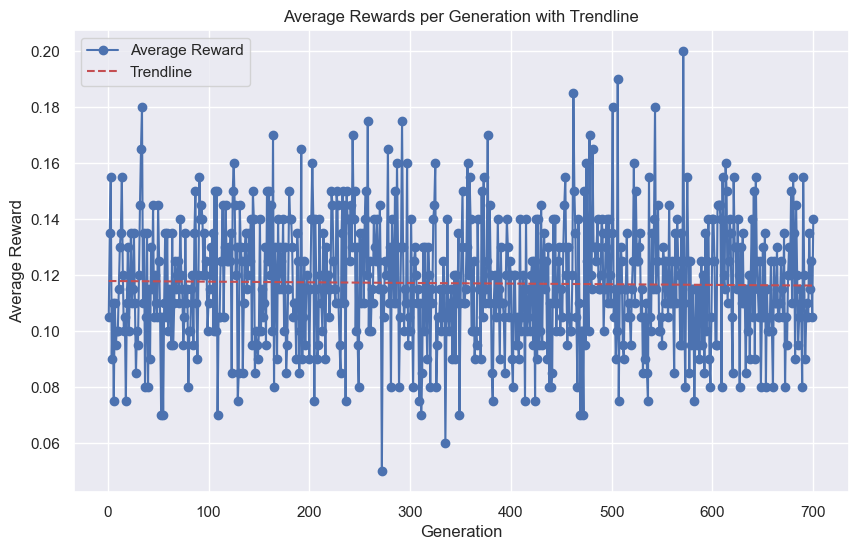

In [6]:
x = np.arange(1, len(avg_rewards_per_generation) + 1)
trendline_coefficients = np.polyfit(x, avg_rewards_per_generation, 1)
trendline = np.polyval(trendline_coefficients, x)

# Plotting the line graph with the trendline
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
plt.plot(x, avg_rewards_per_generation, marker='o', color='b', label='Average Reward')
plt.plot(x, trendline, color='r', linestyle='--', label='Trendline')  # Adding the trendline

# Labels and title
plt.xlabel('Generation')
plt.ylabel('Average Reward')
plt.title('Average Rewards per Generation with Trendline')
plt.legend()
plt.show()

In [7]:
env.reset()  # Reset environment before starting
max_reward = -float('inf')  # Initialize max reward to very low

for _ in range(100):  # Run a number of steps to gather rewards
    action = env.action_space.sample()  # Take a random action
    state, reward, done, truncated, _ = env.step(action)  # Perform the action
    max_reward = max(max_reward, reward)  # Track maximum reward

    if done or truncated:
        env.reset()  # Reset environment if done or truncated

print(f"Maximum reward observed: {max_reward}")

UnityEnvironmentException: No Unity environment is loaded.

In [ ]:
#Only with modified population not hyper params

In [13]:
sns.set()

class ActorCriticNN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU())

        self.policy_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64,action_dim))

        self.value_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def value(self, obs):
        z = self.shared_layers(obs)
        value = self.value_layers(z)
        return value

    def policy(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        return policy_logits

    def forward(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        value = self.value_layers(z)
        return policy_logits, value

#trainer
class PPOTrainer():
    def __init__(self, actor_critic, ppo_clip_val = 0.2, target_kl_div = 0.01, max_policy_train_iters = 80, value_train_iters=80, 
                policy_lr = 3e-4, value_lr = 1e-2, entropy_coeff = 0.1):
        self.ac = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters
        self.entropy_coeff = entropy_coeff
    
        policy_params = list(self.ac.shared_layers.parameters()) + \
            list(self.ac.policy_layers.parameters())
        self.policy_optim = optim.Adam(policy_params, lr = policy_lr)
    
        value_params = list(self.ac.shared_layers.parameters()) + \
            list(self.ac.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr = value_lr)

    def train_policy(self, obs, acts, old_log_probs, gaes):
        """
        Train the policy using PPO with the given observations, actions, old log probabilities, and GAEs.
        """
        # Forward pass through the policy network
        new_logits = self.ac.policy(obs)  # Output from policy network
        new_logits = Categorical(logits=new_logits)

        acts = acts.squeeze(1)
        
        # Ensure actions are reshaped to 1D if necessary
        acts = acts.reshape(-1)  # Flatten actions to a 1D tensor
        
        # Ensure batch sizes match
        batch_size = new_logits.logits.size(0)
        if acts.size(0) != batch_size:
            #print(f"Warning: Mismatch in batch size: logits size {batch_size}, actions size {acts.size(0)}")
            acts = acts[:batch_size]  # Slice actions to match logits batch size
        
        # Compute the log probabilities of the actions
        new_log_probs = new_logits.log_prob(acts)  # This requires acts to be a 1D tensor, not 2D
        
        # Compute the policy ratio
        policy_ratio = torch.exp(new_log_probs - old_log_probs)
        clipped_ratio = policy_ratio.clamp(1 - self.ppo_clip_val, 1 + self.ppo_clip_val)
        
        # Calculate the loss
        loss = -torch.min(policy_ratio * gaes, clipped_ratio * gaes).mean()
        
        # Add entropy bonus to encourage exploration
        #entropy_loss = -torch.mean(new_logits.entropy())
        #loss = loss - self.entropy_coeff * entropy_loss

        # Backpropagate and optimize (assuming optimizer is defined)
        self.policy_optim.zero_grad()
        loss.backward()
        self.policy_optim.step()

        kl_div = (old_log_probs - new_log_probs).mean()


    def train_value(self, obs, returns):

        for _ in range (self.value_train_iters):
            self.value_optim.zero_grad()
    
            values = self.ac.value(obs)
            value_loss = (returns-values) ** 2
            value_loss = value_loss.mean()
    
            value_loss.backward()
            self.value_optim.step()

def create_population(pop_size, state_dim, action_dim):
    return [ActorCriticNN(state_dim, action_dim) for _ in range(pop_size)]

"""
When initializing PPOTrainer, you're passing the individual's hyperparameters (policy_lr, value_lr, etc.) 
to ensure the evaluation process reflects the effect of those hyperparameters.
You're sampling actions from the model and accumulating rewards to calculate the fitness score.
"""

from mlagents_envs.base_env import ActionTuple

def evaluate_population(population, env, behavior_name):
    """
    Evaluate each individual in the population within the Unity environment.
    
    Parameters:
        population (list): List of policies (or models) to evaluate.
        env (UnityEnvironment): Unity environment object.
        behavior_name (str): Name of the behavior being evaluated.
        
    Returns:
        fitness_scores (list): List of fitness scores (rewards) for each individual.
    """
    fitness_scores = []

    for policy in population:
        # Reset the environment and initialize reward for the episode
        env.reset()
        total_reward = 0
        done = False

        while not done:
            # Get the current observation and decision steps
            decision_steps, terminal_steps = env.get_steps(behavior_name)

            if len(decision_steps) > 0:
                # Extract observation data for the agent
                obs = decision_steps.obs[0][0]  # Get the first observation from the agent (assuming single agent)

                # Convert obs to a PyTorch tensor with dtype float32
                obs_tensor = torch.tensor(obs, dtype=torch.float32)

                # Ensure the tensor is correctly shaped for the model (batch dimension)
                if len(obs_tensor.shape) == 1:  # if obs is 1D, add a batch dimension
                    obs_tensor = obs_tensor.unsqueeze(0)

                # Get the action from the policy model
                logits, _ = policy(obs_tensor)  # Assuming 'policy' method returns both logits and value

                # Convert logits into a categorical distribution and sample an action
                action_dist = Categorical(logits=logits)
                action = action_dist.sample().item()  # Get the action as a scalar

                # Ensure action is a 2D array with shape (1, 2) for continuous action space
                action = np.array([[action, action]])  # Example to make action a 2D array

                # Convert the action to the correct Unity format
                action_tuple = ActionTuple(continuous=action)

                # Set the action and step the environment
                env.set_actions(behavior_name, action_tuple)
                env.step()

            # Collect rewards from decision and terminal steps
            for agent_id in decision_steps:
                total_reward += decision_steps[agent_id].reward
            
            for agent_id in terminal_steps:
                total_reward += terminal_steps[agent_id].reward
                done = True  # End of episode if there are terminal steps

        # Append the total reward as the fitness score for the policy
        fitness_scores.append(total_reward)

    return fitness_scores



def select_parents(population, fitness_scores, num_parents):
   # Get indices that would sort the fitness scores in descending order
    sorted_indices = np.argsort(fitness_scores)[::-1]  # Reverse for descending order
    
    # Select the best parents based on the sorted indices
    parents = np.array(population)[sorted_indices][:num_parents]
    return parents.tolist()

def crossover(parent1, parent2):
    child = ActorCriticNN(state_dim, action_dim)
    
    # Crossover the weights of the model in a way that keeps useful features
    for param1, param2, param_child in zip(parent1.parameters(), parent2.parameters(), child.parameters()):
        param_child.data = (param1.data + param2.data) / 2  # Averaging weights of the parents
    
    return child


def mutate(individual, mutation_rate=0.01):
    for param in individual.parameters():
        if random.random() < mutation_rate:
            param.data += torch.randn(param.size()) * 0.1  # Add small random noise



def discount_rewards(rewards, gamma = 0.99):
    """
    Return discounted rewards based on the given rewards and the gamma param.
    """

    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards)-1)):
        new_rewards.append(float(rewards[i]) + gamma * new_rewards[-1])
    return np.array(new_rewards[::-1])

def calculate_gaes(rewards, values, gamma = 0.99, decay = 0.97):
    """
    Return the General Advantage Estimates from the given rewards and values.
    Paper: https://arxiv.org/abs/1506.02438
    """

    next_values = np.concatenate([values[1:], [0]])
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas)-1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])

    return np.array(gaes[::-1])

def unity_rollout(model, env, name, max_steps=1000, gamma=0.99, lam=0.95):
    """
    Perform a rollout of the model in the Unity environment and collect rewards, 
    actions, values, and log probabilities.

    Parameters:
        model (torch.nn.Module): The trained policy model.
        env (UnityEnvironment): The Unity environment object.
        name (str): The behavior name for the agent.
        max_steps (int): Maximum number of steps in an episode.

    Returns:
        train_data (tuple): Collected training data (observations, actions, rewards, values, log_probs).
        reward (float): Total reward for the episode.
    """
    train_data = [[], [], [], [], []]  # To store observations, actions, rewards, values, log_probs
    total_reward = 0
    done = False
    step = 0

    # Reset environment at the start
    env.reset()

    while not done and step < max_steps:
        decision_steps, terminal_steps = env.get_steps(name)

        if len(decision_steps) > 0:
            # Get observation from the environment
            obs = decision_steps.obs[0][0]  # Assuming single agent
            
            # Convert the observation to a tensor
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

            # Get the action and value from the policy model
            action_logits, value = model(obs_tensor)

            # Ensure the action is a 2D tensor (1, 2) for continuous action space
            if action_logits.shape != (1, 2):
                action_logits = action_logits.reshape(1, 2)  # Reshape to (1, 2) if necessary

            # Create action distribution and sample an action
            act_dist = Categorical(logits=action_logits)
            action = act_dist.sample()
            act_log_prob = act_dist.log_prob(action).item()

            # Ensure action has the correct shape (1, 2) for continuous action
            if action.shape == (1,):  # Check if action is a single value
                action = action.unsqueeze(0)  # Reshape to (1, 2) if it's a scalar
                action = action.expand(1, 2)  # Duplicate the value to match the shape (1, 2)

            # Store the observation, action, reward, value, and log probability
            train_data[0].append(obs)  # Observation
            train_data[1].append(action.detach().numpy())  # Action
            train_data[2].append(decision_steps[0].reward)  # Reward (for decision steps)
            train_data[3].append(value.item())  # Value from the model
            train_data[4].append(act_log_prob)  # Log probability of the action

            # Set the action and step the environment
            action_tuple = ActionTuple()
            action_tuple.add_continuous(action.detach().numpy())  # Detach the tensor before converting to numpy
            env.set_actions(name, action_tuple)
            env.step()

            # Collect rewards
            for agent_id in decision_steps:
                total_reward += decision_steps[agent_id].reward

            # Check if the episode has ended (by terminal steps)
            if len(terminal_steps) > 0:
                for agent_id in terminal_steps:
                    total_reward += terminal_steps[agent_id].reward
                    # Store at the end of the episode
                    train_data[0].append(obs)
                    train_data[1].append(action.detach().numpy())
                    train_data[2].append(terminal_steps[agent_id].reward)
                    train_data[3].append(value.item())  # Final value prediction
                    train_data[4].append(act_log_prob)  # Final log probability
                done = True

        step += 1

    # Convert lists to numpy arrays
    train_data = [np.asarray(x) for x in train_data]

    # Calculate GAEs using the stored rewards and values
    train_data[3] = calculate_gaes(train_data[2], train_data[3], gamma, lam)

    return train_data, total_reward

worker_id = 0
show_visuals = False;
while worker_id <= 64:
    try:
        env = UnityEnvironment(file_name="../Evo_Project", worker_id=worker_id, no_graphics=not show_visuals)
        env.reset()
        break
    except UnityWorkerInUseException:
        worker_id += 1

# Keep top N best individuals
def elitism(population, fitness_scores, num_best=5):
    sorted_indices = np.argsort(fitness_scores)[::-1]  # Descending order of fitness scores
    best_individuals = [population[i] for i in sorted_indices[:num_best]]
    return best_individuals

def adaptive_mutation_rate(generation, max_generations, initial_rate=0.1, min_rate=0.01):
    # Linearly decay mutation rate from initial_rate to min_rate over generations
    rate = initial_rate - (initial_rate - min_rate) * (generation / max_generations)
    return rate

def evolutionary_process(population, fitness_scores, num_parents, pop_size):
    
    # Create next generation using selected parents
    next_generation = []
    for i in range(pop_size):
        parent1, parent2 = np.random.choice(parents, 2, replace=False)  # Select parents from the elite
        child = crossover(parent1, parent2)
        mutate(child)  # Apply mutation
        next_generation.append(child)

    return next_generation

behavior_name = list(env.behavior_specs.keys())[0]
spec = env.behavior_specs[behavior_name]
state_dim = sum([obs.shape[0] for obs in spec.observation_specs])  # Total observation dimensions
action_spec = spec.action_spec
action_dim = action_spec.discrete_size if action_spec.is_discrete() else action_spec.continuous_size

# Define the environment and parameters
# state_dim = env.observation_space.shape[0]
# action_dim = env.action_space.n
n_episodes = 200
print_freq = 20
pop_size = 50
num_parents = 10
num_generations = 50


# Initialize the population
population = create_population(pop_size, state_dim, action_dim)

for generation in range(num_generations):
    
        # Evaluate the current population
        fitness_scores = evaluate_population(population, env, behavior_name)

        # Elitism: select the top 5 individuals based on fitness
        parents = elitism(population, fitness_scores, num_best=5)

        # Select the best parents based on fitness scores
        parents = select_parents(population, fitness_scores, num_parents)

        # Apply the evolutionary process to generate the next generation
        next_generation = evolutionary_process(parents, fitness_scores, num_parents, pop_size)

        print(f"Generation: {generation + 1}")

        # Fine-tune the best policy using PPO
        best_policy = parents[0]  # Select the best policy for further training with PPO
        ppo =  ppo = PPOTrainer(best_policy, policy_lr=3e-4, value_lr=1e-3, target_kl_div=0.02, max_policy_train_iters=80, value_train_iters=80)

        ep_rewards = []
        for episode_idx in range(n_episodes):
            # Perform rollout
            train_data, reward = unity_rollout(best_policy, env, behavior_name)
            ep_rewards.append(reward)

            # Permute the indices
            permute_idxs = np.random.permutation(len(train_data[0]))

            # Convert the train_data[0] (observations) and train_data[1] (actions) to torch tensors
            obs = torch.tensor(np.array(train_data[0])[permute_idxs], dtype=torch.float32)
            act = torch.tensor(np.array(train_data[1])[permute_idxs], dtype=torch.float32)
            gaes = torch.tensor(np.array(train_data[3])[permute_idxs], dtype=torch.float32)  # If using GAEs, ensure it's in train_data[3]

            act_log_probs = torch.tensor(train_data[4][permute_idxs], dtype=torch.float32)

            # Value Data
            returns = discount_rewards(train_data[2])[permute_idxs]
            returns = torch.tensor(returns, dtype=torch.float32)

            # Train Policy
            ppo.train_policy(obs, act, act_log_probs, gaes)
            ppo.train_value(obs, returns)

            # Print average reward every 'print_freq' episodes
            if (episode_idx + 1) % print_freq == 0:
                avg_reward = np.mean(ep_rewards[-print_freq:])  # Calculate the average of the last 'print_freq' rewards
                print(f'Generation {generation + 1} | Episode {episode_idx + 1} | Avg Reward {avg_reward:.1f}')

        # Calculate and print the overall average reward for this generation
        generation_avg_reward = np.mean(ep_rewards)  # Calculate average for all episodes in this generation
        print(f"Generation {generation + 1} Average Reward: {generation_avg_reward:.1f}")

        # Set the population for the next generation
        population = next_generation

        # Reset the environment for the next generation
        env.reset()

    # After training finishes
env.close()

I0000 00:00:1731500056.625042 8729940 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [ ]:
# With a Replay Buffer Below and modified hyperparams

In [ ]:
sns.set()

class ActorCriticNN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU())

        self.policy_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64,action_dim))

        self.value_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def value(self, obs):
        z = self.shared_layers(obs)
        value = self.value_layers(z)
        return value

    def policy(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        return policy_logits

    def forward(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        value = self.value_layers(z)
        return policy_logits, value

#trainer
class PPOTrainer():
    def __init__(self, actor_critic, ppo_clip_val, target_kl_div, policy_lr, value_lr, max_policy_train_iters = 80, 
                 value_train_iters = 80, entropy_coeff = 0.01):
        self.entropy_coeff = entropy_coeff
        self.ac = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters
    
        policy_params = list(self.ac.shared_layers.parameters()) + \
            list(self.ac.policy_layers.parameters())
        self.policy_optim = optim.Adam(policy_params, lr = policy_lr)
    
        value_params = list(self.ac.shared_layers.parameters()) + \
            list(self.ac.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr = value_lr)

    def train_policy(self, obs, acts, old_log_probs, gaes):
        """
        Train the policy using PPO with the given observations, actions, old log probabilities, and GAEs.
        """
        # Forward pass through the policy network
        new_logits = self.ac.policy(obs)  # Output from policy network
        new_logits = Categorical(logits=new_logits)

        acts = acts.squeeze(1)
        
        # Ensure actions are reshaped to 1D if necessary
        acts = acts.reshape(-1)  # Flatten actions to a 1D tensor
        
        # Ensure batch sizes match
        batch_size = new_logits.logits.size(0)
        if acts.size(0) != batch_size:
            #print(f"Warning: Mismatch in batch size: logits size {batch_size}, actions size {acts.size(0)}")
            acts = acts[:batch_size]  # Slice actions to match logits batch size
        
        # Compute the log probabilities of the actions
        new_log_probs = new_logits.log_prob(acts)  # This requires acts to be a 1D tensor, not 2D
        
        # Compute the policy ratio
        policy_ratio = torch.exp(new_log_probs - old_log_probs)
        clipped_ratio = policy_ratio.clamp(1 - self.ppo_clip_val, 1 + self.ppo_clip_val)
        
        # Calculate the loss
        loss = -torch.min(policy_ratio * gaes, clipped_ratio * gaes).mean()
        
        # Add entropy bonus to encourage exploration
        #entropy_loss = -torch.mean(new_logits.entropy())
        #loss = loss - self.entropy_coeff * entropy_loss

        # Backpropagate and optimize (assuming optimizer is defined)
        self.policy_optim.zero_grad()
        loss.backward()
        self.policy_optim.step()

        kl_div = (old_log_probs - new_log_probs).mean()


    def train_value(self, obs, returns):

        for _ in range (self.value_train_iters):
            self.value_optim.zero_grad()
    
            values = self.ac.value(obs)
            value_loss = (returns-values) ** 2
            value_loss = value_loss.mean()
    
            value_loss.backward()
            self.value_optim.step()

class ActorCriticChromosome:
    def __init__(self, state_dim, action_dim):
        # Actor-Critic neural network
        self.model = ActorCriticNN(state_dim, action_dim)

        #Hyperparameters
        self.policy_lr = random.uniform(1e-5, 1e-2)  # Expanded range
        self.value_lr = random.uniform(1e-5, 1e-2)  # Expanded range
        self.ppo_clip_val = random.uniform(0.1, 0.4)  # Expanded range
        self.target_kl_div = random.uniform(0.001, 0.05)

def create_population(pop_size, state_dim, action_dim):
    return [ActorCriticChromosome(state_dim, action_dim) for _ in range(pop_size)]

"""
When initializing PPOTrainer, you're passing the individual's hyperparameters (policy_lr, value_lr, etc.) 
to ensure the evaluation process reflects the effect of those hyperparameters.
You're sampling actions from the model and accumulating rewards to calculate the fitness score.
"""

from mlagents_envs.base_env import ActionTuple

def evaluate_population(population, env, behavior_name):
    """
    Evaluate each individual in the population within the Unity environment.
    
    Parameters:
        population (list): List of policies (or models) to evaluate.
        env (UnityEnvironment): Unity environment object.
        behavior_name (str): Name of the behavior being evaluated.
        
    Returns:
        fitness_scores (list): List of fitness scores (rewards) for each individual.
    """
    fitness_scores = []

    for policy in population:
        # Reset the environment and initialize reward for the episode
        env.reset()
        total_reward = 0
        done = False

        while not done:
            # Get the current observation and decision steps
            decision_steps, terminal_steps = env.get_steps(behavior_name)

            if len(decision_steps) > 0:
                # Extract observation data for the agent
                obs = decision_steps.obs[0][0]  # Get the first observation from the agent (assuming single agent)

                # Convert obs to a PyTorch tensor with dtype float32
                obs_tensor = torch.tensor(obs, dtype=torch.float32)

                # Ensure the tensor is correctly shaped for the model (batch dimension)
                if len(obs_tensor.shape) == 1:  # if obs is 1D, add a batch dimension
                    obs_tensor = obs_tensor.unsqueeze(0)

                # Get the action from the policy model
                logits, _ = policy.model(obs_tensor)  # Assuming 'policy' method returns both logits and value

                # Convert logits into a categorical distribution and sample an action
                action_dist = Categorical(logits=logits)
                action = action_dist.sample().item()  # Get the action as a scalar

                # Ensure action is a 2D array with shape (1, 2) for continuous action space
                action = np.array([[action, action]])  # Example to make action a 2D array

                # Convert the action to the correct Unity format
                action_tuple = ActionTuple(continuous=action)

                # Set the action and step the environment
                env.set_actions(behavior_name, action_tuple)
                env.step()

            # Collect rewards from decision and terminal steps
            for agent_id in decision_steps:
                total_reward += decision_steps[agent_id].reward
            
            for agent_id in terminal_steps:
                total_reward += terminal_steps[agent_id].reward
                done = True  # End of episode if there are terminal steps

        # Append the total reward as the fitness score for the policy
        fitness_scores.append(total_reward)

    return fitness_scores



def select_parents(population, fitness_scores, num_parents):
   # Get indices that would sort the fitness scores in descending order
    sorted_indices = np.argsort(fitness_scores)[::-1]  # Reverse for descending order
    
    # Select the best parents based on the sorted indices
    parents = np.array(population)[sorted_indices][:num_parents]
    return parents.tolist()

def crossover(parent1, parent2):
    child = ActorCriticChromosome(state_dim, action_dim)
    
    # Crossover the weights of the model in a way that keeps useful features
    for param1, param2, param_child in zip(parent1.model.parameters(), parent2.model.parameters(), child.model.parameters()):
        param_child.data = (param1.data + param2.data) / 2  # Averaging weights of the parents

    # Crossover the hyperparameters (keeping them in a range that allows for continued learning)
    child.policy_lr = (parent1.policy_lr + parent2.policy_lr) / 2
    child.value_lr = (parent1.value_lr + parent2.value_lr) / 2
    child.ppo_clip_val = (parent1.ppo_clip_val + parent2.ppo_clip_val) / 2
    child.target_kl_div = (parent1.target_kl_div + parent2.target_kl_div) / 2
    
    return child


def mutate(individual, mutation_rate=0.01):
    for param in individual.model.parameters():
        if random.random() < mutation_rate:
            param.data += torch.randn(param.size()) * 0.1  # Add small random noise
    
    # Mutate hyperparameters with greater changes
    if random.random() < mutation_rate:
        individual.policy_lr += random.uniform(-5e-4, 5e-4)  # Much larger mutation range
    if random.random() < mutation_rate:
        individual.value_lr += random.uniform(-5e-4, 5e-4)  # Increased mutation range
    if random.random() < mutation_rate:
        individual.ppo_clip_val += random.uniform(-0.1, 0.1)  # Increased mutation range
    if random.random() < mutation_rate:
        individual.target_kl_div += random.uniform(-0.01, 0.01)  # Increased mutation range



def discount_rewards(rewards, gamma = 0.99):
    """
    Return discounted rewards based on the given rewards and the gamma param.
    """

    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards)-1)):
        new_rewards.append(float(rewards[i]) + gamma * new_rewards[-1])
    return np.array(new_rewards[::-1])

def calculate_gaes(rewards, values, gamma = 0.99, decay = 0.97):
    """
    Return the General Advantage Estimates from the given rewards and values.
    Paper: https://arxiv.org/abs/1506.02438
    """

    next_values = np.concatenate([values[1:], [0]])
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas)-1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])

    return np.array(gaes[::-1])

def unity_rollout(model, env, name, max_steps=1000, gamma=0.99, lam=0.95):
    """
    Perform a rollout of the model in the Unity environment and collect rewards, 
    actions, values, and log probabilities.

    Parameters:
        model (torch.nn.Module): The trained policy model.
        env (UnityEnvironment): The Unity environment object.
        name (str): The behavior name for the agent.
        max_steps (int): Maximum number of steps in an episode.

    Returns:
        train_data (tuple): Collected training data (observations, actions, rewards, values, log_probs).
        reward (float): Total reward for the episode.
    """
    train_data = [[], [], [], [], []]  # To store observations, actions, rewards, values, log_probs
    total_reward = 0
    done = False
    step = 0

    # Reset environment at the start
    env.reset()

    while not done and step < max_steps:
        decision_steps, terminal_steps = env.get_steps(name)

        if len(decision_steps) > 0:
            # Get observation from the environment
            obs = decision_steps.obs[0][0]  # Assuming single agent
            
            # Convert the observation to a tensor
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

            # Get the action and value from the policy model
            action_logits, value = model(obs_tensor)

            # Ensure the action is a 2D tensor (1, 2) for continuous action space
            if action_logits.shape != (1, 2):
                action_logits = action_logits.reshape(1, 2)  # Reshape to (1, 2) if necessary

            # Create action distribution and sample an action
            act_dist = Categorical(logits=action_logits)
            action = act_dist.sample()
            act_log_prob = act_dist.log_prob(action).item()

            # Ensure action has the correct shape (1, 2) for continuous action
            if action.shape == (1,):  # Check if action is a single value
                action = action.unsqueeze(0)  # Reshape to (1, 2) if it's a scalar
                action = action.expand(1, 2)  # Duplicate the value to match the shape (1, 2)

            # Store the observation, action, reward, value, and log probability
            train_data[0].append(obs)  # Observation
            train_data[1].append(action.detach().numpy())  # Action
            train_data[2].append(decision_steps[0].reward)  # Reward (for decision steps)
            train_data[3].append(value.item())  # Value from the model
            train_data[4].append(act_log_prob)  # Log probability of the action

            # Set the action and step the environment
            action_tuple = ActionTuple()
            action_tuple.add_continuous(action.detach().numpy())  # Detach the tensor before converting to numpy
            env.set_actions(name, action_tuple)
            env.step()

            # Collect rewards
            for agent_id in decision_steps:
                total_reward += decision_steps[agent_id].reward

            # Check if the episode has ended (by terminal steps)
            if len(terminal_steps) > 0:
                for agent_id in terminal_steps:
                    total_reward += terminal_steps[agent_id].reward
                    # Store at the end of the episode
                    train_data[0].append(obs)
                    train_data[1].append(action.detach().numpy())
                    train_data[2].append(terminal_steps[agent_id].reward)
                    train_data[3].append(value.item())  # Final value prediction
                    train_data[4].append(act_log_prob)  # Final log probability
                done = True

        step += 1

    # Convert lists to numpy arrays
    train_data = [np.asarray(x) for x in train_data]

    # Calculate GAEs using the stored rewards and values
    train_data[3] = calculate_gaes(train_data[2], train_data[3], gamma, lam)

    return train_data, total_reward

worker_id = 0
show_visuals = False;
while worker_id <= 64:
    try:
        env = UnityEnvironment(file_name="../Evo_Project", worker_id=worker_id, no_graphics=not show_visuals)
        env.reset()
        break
    except UnityWorkerInUseException:
        worker_id += 1

# Keep top N best individuals
def elitism(population, fitness_scores, num_best=5):
    sorted_indices = np.argsort(fitness_scores)[::-1]  # Descending order of fitness scores
    best_individuals = [population[i] for i in sorted_indices[:num_best]]
    return best_individuals

def adaptive_mutation_rate(generation, max_generations, initial_rate=0.1, min_rate=0.01):
    # Linearly decay mutation rate from initial_rate to min_rate over generations
    rate = initial_rate - (initial_rate - min_rate) * (generation / max_generations)
    return rate

def evolutionary_process(population, fitness_scores, num_parents, pop_size):
    
    # Create next generation using selected parents
    next_generation = []
    for i in range(pop_size):
        parent1, parent2 = np.random.choice(parents, 2, replace=False)  # Select parents from the elite
        child = crossover(parent1, parent2)
        mutate(child)  # Apply mutation
        next_generation.append(child)

    return next_generation

class ReplayBuffer:
    def __init__(self, capacity, num_steps=1, gamma=0.99):
        self.capacity = int(capacity)
        self.num_steps = int(num_steps)
        self.gamma = gamma
        self.buffer = deque(maxlen=self.capacity)
        self.n_step_buffer = deque(maxlen=self.num_steps)

    def add(self, transition):
        assert len(transition) == 6  # (state, action, reward, next_state, terminated, truncated)

        if self.num_steps == 1:
            state, action, reward, next_state, terminated, truncated = transition
            self.buffer.append((state, action, reward, next_state, terminated))
        else:
            self.n_step_buffer.append(transition)
            _, _, _, final_state, final_terminated, final_truncated = transition
            n_step_reward = 0

            for _, _, reward, _, _, _ in reversed(self.n_step_buffer):
                n_step_reward = (n_step_reward * self.gamma) + reward
            state, action, _, _, _, _ = self.n_step_buffer[0]

            if len(self.n_step_buffer) == self.num_steps:
                self.buffer.append((state, action, n_step_reward, final_state, final_terminated))

            if final_terminated or final_truncated:
                self.n_step_buffer.clear()

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

behavior_name = list(env.behavior_specs.keys())[0]
spec = env.behavior_specs[behavior_name]
state_dim = sum([obs.shape[0] for obs in spec.observation_specs])  # Total observation dimensions
action_spec = spec.action_spec
action_dim = action_spec.discrete_size if action_spec.is_discrete() else action_spec.continuous_size

# Define the environment and parameters
# state_dim = env.observation_space.shape[0]
# action_dim = env.action_space.n
n_episodes = 200
print_freq = 20
pop_size = 50
num_parents = 10
num_generations = 50

replay_buffer = ReplayBuffer(capacity=10000, num_steps=3, gamma=0.99)


# Initialize the population
population = create_population(pop_size, state_dim, action_dim)

for generation in range(num_generations):
    
        # Evaluate the current population
        fitness_scores = evaluate_population(population, env, behavior_name)

        # Elitism: select the top 5 individuals based on fitness
        parents = elitism(population, fitness_scores, num_best=5)

        # Select the best parents based on fitness scores
        parents = select_parents(population, fitness_scores, num_parents)

        # Apply the evolutionary process to generate the next generation
        next_generation = evolutionary_process(parents, fitness_scores, num_parents, pop_size)

        print(f"Generation: {generation + 1}")

        # Fine-tune the best policy using PPO
        best_policy = parents[0]  # Select the best policy for further training with PPO
        ppo = PPOTrainer(best_policy.model, ppo_clip_val=best_policy.ppo_clip_val, target_kl_div=best_policy.target_kl_div,
                         policy_lr=best_policy.policy_lr, value_lr=best_policy.value_lr)

        ep_rewards = []
        for episode_idx in range(n_episodes):
            # Perform rollout
            train_data, reward = unity_rollout(best_policy.model, env, behavior_name)
            ep_rewards.append(reward)

            for t in range(len(train_data[0])):
                state = train_data[0][t]
                action = train_data[1][t]
                reward = train_data[2][t]
                next_state = train_data[3][t]
                done = train_data[4][t]
                replay_buffer.add((state, action, reward, next_state, done, False))

            ep_rewards.append(reward)

            # Sample a batch from the buffer for training
            if len(replay_buffer) > 64:
                states, actions, rewards, next_states, dones = replay_buffer.sample(64)

                # Convert data to torch tensors
                states = torch.tensor(states, dtype=torch.float32)
                actions = torch.tensor(actions, dtype=torch.float32)
                rewards = torch.tensor(rewards, dtype=torch.float32)
                next_states = torch.tensor(next_states, dtype=torch.float32)
                dones = torch.tensor(dones, dtype=torch.float32)

                # Calculate returns and advantages (if needed)
                returns = discount_rewards(rewards)
                gaes = compute_gaes(rewards, next_states, dones)

                # Train PPO with the sampled batch
                ppo.train_policy(states, actions, gaes)
                ppo.train_value(states, returns)

            # Print average reward every 'print_freq' episodes
            if (episode_idx + 1) % print_freq == 0:
                avg_reward = np.mean(ep_rewards[-print_freq:])
                print(f'Generation {generation + 1} | Episode {episode_idx + 1} | Avg Reward {avg_reward:.1f}')

        # Calculate overall average reward for the generation
        generation_avg_reward = np.mean(ep_rewards)
        print(f"Generation {generation + 1} Average Reward: {generation_avg_reward:.1f}")

        # Set population for next generation
        population = next_generation

        # Reset environment for the next generation
        env.reset()

    # After training finishes
env.close()

In [ ]:
#Just PPO

In [17]:

sns.set()

class ActorCriticNN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU())

        self.policy_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim))

        self.value_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

    def value(self, obs):
        z = self.shared_layers(obs)
        value = self.value_layers(z)
        return value

    def policy(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        return policy_logits

    def forward(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        value = self.value_layers(z)
        return policy_logits, value


class PPOTrainer:
    def __init__(self, actor_critic, ppo_clip_val, target_kl_div, policy_lr, value_lr, max_policy_train_iters=80,
                 value_train_iters=80):
        self.ac = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters

        policy_params = list(self.ac.shared_layers.parameters()) + \
                         list(self.ac.policy_layers.parameters())
        self.policy_optim = optim.Adam(policy_params, lr=policy_lr)

        value_params = list(self.ac.shared_layers.parameters()) + \
                        list(self.ac.value_layers.parameters())
        self.value_optim = optim.Adam(value_params, lr=value_lr)

    def train_policy(self, obs, acts, old_log_probs, gaes):
        """
        Train the policy using PPO with the given observations, actions, old log probabilities, and GAEs.
        """
        # Forward pass through the policy network
        new_logits = self.ac.policy(obs)  # Output from policy network
        new_logits = Categorical(logits=new_logits)

        acts = acts.squeeze(1)
        
        # Ensure actions are reshaped to 1D if necessary
        acts = acts.reshape(-1)  # Flatten actions to a 1D tensor
        
        # Compute the log probabilities of the actions
        new_log_probs = new_logits.log_prob(acts)
        
        # Compute the policy ratio
        policy_ratio = torch.exp(new_log_probs - old_log_probs)
        clipped_ratio = policy_ratio.clamp(1 - self.ppo_clip_val, 1 + self.ppo_clip_val)
        
        # Calculate the loss
        loss = -torch.min(policy_ratio * gaes, clipped_ratio * gaes).mean()

        # Backpropagate and optimize
        self.policy_optim.zero_grad()
        loss.backward()
        self.policy_optim.step()

    def train_value(self, obs, returns):
        for _ in range(self.value_train_iters):
            self.value_optim.zero_grad()

            values = self.ac.value(obs)
            value_loss = (returns - values) ** 2
            value_loss = value_loss.mean()

            value_loss.backward()
            self.value_optim.step()


def unity_rollout(model, env, name, max_steps=1000, gamma=0.99, lam=0.95):
    train_data = [[], [], [], [], []]  # To store observations, actions, rewards, values, log_probs
    total_reward = 0
    done = False
    step = 0

    # Reset environment at the start
    env.reset()

    while not done and step < max_steps:
        decision_steps, terminal_steps = env.get_steps(name)

        if len(decision_steps) > 0:
            # Get observation from the environment
            obs = decision_steps.obs[0][0]  # Assuming single agent
            
            # Convert the observation to a tensor
            obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

            # Get the action and value from the policy model
            action_logits, value = model(obs_tensor)

            # Create action distribution and sample an action
            act_dist = Categorical(logits=action_logits)
            action = act_dist.sample()
            act_log_prob = act_dist.log_prob(action).item()

            # Store the observation, action, reward, value, and log probability
            train_data[0].append(obs)  # Observation
            train_data[1].append(action.detach().numpy())  # Action
            train_data[2].append(decision_steps[0].reward)  # Reward
            train_data[3].append(value.item())  # Value from the model
            train_data[4].append(act_log_prob)  # Log probability of the action

           # Ensure action has the correct shape (1, 2) for continuous action
            if action.shape == (1,):  # Check if action is a single value
                action = action.unsqueeze(0)  # Reshape to (1, 2) if it's a scalar
                action = action.expand(1, 2)  # Duplicate the value to match the shape (1, 2)

            # Modify this line in unity_rollout() function
            action_tuple = ActionTuple()
            action_tuple.add_continuous(action.detach().numpy().reshape(1, -1))  # Reshape to (1, action_dim)
            env.set_actions(name, action_tuple)

            # Collect rewards
            for agent_id in decision_steps:
                total_reward += decision_steps[agent_id].reward

            # Check if the episode has ended
            if len(terminal_steps) > 0:
                for agent_id in terminal_steps:
                    total_reward += terminal_steps[agent_id].reward
                done = True

        step += 1

    # Calculate GAEs using the stored rewards and values
    train_data[3] = calculate_gaes(train_data[2], train_data[3], gamma, lam)

    return train_data, total_reward


def calculate_gaes(rewards, values, gamma=0.99, decay=0.97):
    next_values = np.concatenate([values[1:], [0]])
    deltas = [rew + gamma * next_val - val for rew, val, next_val in zip(rewards, values, next_values)]

    gaes = [deltas[-1]]
    for i in reversed(range(len(deltas) - 1)):
        gaes.append(deltas[i] + decay * gamma * gaes[-1])

    return np.array(gaes[::-1])


def discount_rewards(rewards, gamma=0.99):
    new_rewards = [float(rewards[-1])]
    for i in reversed(range(len(rewards) - 1)):
        new_rewards.append(float(rewards[i]) + gamma * new_rewards[-1])
    return np.array(new_rewards[::-1])


# Main training loop
def train_ppo(env, behavior_name, state_dim, action_dim, n_episodes=200, print_freq=20):
    # Initialize the policy model and PPO trainer
    model = ActorCriticNN(state_dim, action_dim)
    ppo = PPOTrainer(model, ppo_clip_val=0.2, target_kl_div=0.01, policy_lr=1e-3, value_lr=1e-3)

    ep_rewards = []
    for episode_idx in range(n_episodes):
        # Perform rollout
        train_data, reward = unity_rollout(model, env, behavior_name)
        ep_rewards.append(reward)

        # Permute the indices
        permute_idxs = np.random.permutation(len(train_data[0]))

        # Convert the train_data[0] (observations) and train_data[1] (actions) to torch tensors
        obs = torch.tensor(np.array(train_data[0])[permute_idxs], dtype=torch.float32)
        act = torch.tensor(np.array(train_data[1])[permute_idxs], dtype=torch.float32)
        gaes = torch.tensor(np.array(train_data[3])[permute_idxs], dtype=torch.float32)

        train_data_4 = np.array(train_data[4])  # Convert to numpy array
        act_log_probs = torch.tensor(train_data_4[permute_idxs], dtype=torch.float32)

        # Value Data
        returns = discount_rewards(train_data[2])[permute_idxs]
        returns = torch.tensor(returns, dtype=torch.float32)

        # Train Policy
        ppo.train_policy(obs, act, act_log_probs, gaes)
        ppo.train_value(obs, returns)

        # Print average reward every 'print_freq' episodes
        if (episode_idx + 1) % print_freq == 0:
            avg_reward = np.mean(ep_rewards[-print_freq:])
            print(f'Episode {episode_idx + 1} | Avg Reward {avg_reward:.1f}')

    # Final training statistics
    print(f"Final Average Reward: {np.mean(ep_rewards):.1f}")
    env.close()

# Initialize environment and training parameters
worker_id = 0
show_visuals = False
while worker_id <= 64:
    try:
        env = UnityEnvironment(file_name="../Evo_Project", worker_id=worker_id, no_graphics=not show_visuals)
        env.reset()
        break
    except UnityWorkerInUseException:
        worker_id += 1

behavior_name = list(env.behavior_specs.keys())[0]
spec = env.behavior_specs[behavior_name]
state_dim = sum([obs.shape[0] for obs in spec.observation_specs])  # Aggregate state dimensions
action_dim = spec.action_spec.continuous_size

train_ppo(env, behavior_name, state_dim, action_dim, n_episodes=200)


I0000 00:00:1731534604.848875 8891042 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz